In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create an empty file for the model weights
with open('/content/drive/MyDrive/weight/Full_Models.h5', 'w') as f:
    pass  # Empty block


In [ ]:
!unzip /content/drive/MyDrive/TRAIN.zip -d /content/DATA

In [ ]:
!unzip /content/drive/MyDrive/VAL.zip -d /content/DATA

In [ ]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, UpSampling2D, RepeatVector, Reshape, concatenate ,Dense,GlobalAveragePooling2D
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from skimage.color import gray2rgb, rgb2gray, rgb2lab , lab2rgb
import matplotlib.pyplot as plt

Found 27000 images belonging to 1 classes.
Found 3000 images belonging to 1 classes.
Epoch 1/90
540/540 [==============================] - 550s 1s/step - loss: 0.0068 - val_loss: 0.0058
Epoch 2/90
540/540 [==============================] - 553s 1s/step - loss: 0.0057 - val_loss: 0.0055
Epoch 3/90
540/540 [==============================] - 551s 1s/step - loss: 0.0055 - val_loss: 0.0054
Epoch 4/90
540/540 [==============================] - 538s 998ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 5/90
540/540 [==============================] - 537s 996ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 6/90
540/540 [==============================] - 544s 1s/step - loss: 0.0053 - val_loss: 0.0051
Epoch 7/90
540/540 [==============================] - 546s 1s/step - loss: 0.0053 - val_loss: 0.0051
Epoch 8/90
540/540 [==============================] - 544s 1s/step - loss: 0.0053 - val_loss: 0.0051
Epoch 9/90
540/540 [==============================] - 546s 1s/step - loss: 0.0052 - val_loss: 0.0051


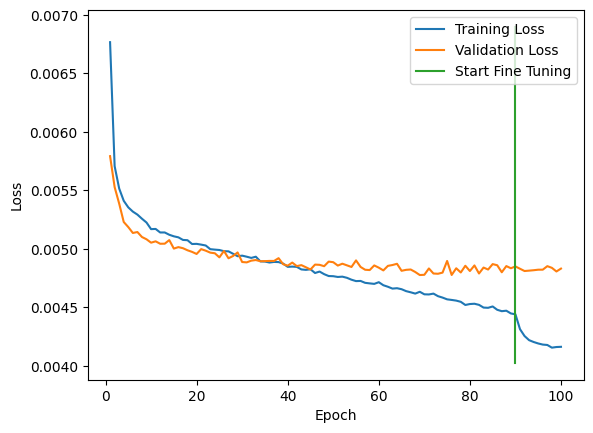

In [ ]:
#Load weights
inception = InceptionV3(weights='imagenet', include_top=False)
# Freeze base model
inception.trainable = False
# Extract global feature
x = inception.output
x = GlobalAveragePooling2D()(x)
inception_model = Model(inputs=inception.input, outputs=x)

embed_input = Input(shape=(2048,))
encoder_input = Input(shape=(224, 224, 1,))

#Encoder
encoder_output1 = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output2 = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output1)
encoder_output3 = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output2)
encoder_output4 = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output3)
encoder_output5 = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output4)
encoder_output6 = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output5)
encoder_output7 = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output6)
encoder_output8 = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output7)

#Fusion
fusion_output = RepeatVector(28 * 28)(embed_input)
fusion_output = Reshape(([28, 28, 2048]))(fusion_output)
fusion_output = concatenate([encoder_output8, fusion_output], axis=3)
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output)

#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_output = concatenate([encoder_output6, decoder_output], axis=3)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = concatenate([encoder_output4, decoder_output], axis=3)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = concatenate([encoder_output2, decoder_output], axis=3)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

model = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

@tf.function
def create_inception_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    for i in grayscaled_rgb:
        resized = tf.image.resize(i, (299, 299))
        resized = preprocess_input(resized)
        grayscaled_rgb_resized = grayscaled_rgb_resized.write(grayscaled_rgb_resized.size(), resized)
    grayscaled_rgb_resized = grayscaled_rgb_resized.stack()
    embed = inception_model(grayscaled_rgb_resized)
    return embed

# Image transformer
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True
        )

val_datagen = ImageDataGenerator(rescale=1./255)

#Generate training data
batch_size = 50

train_iterator = train_datagen.flow_from_directory(
        directory='/content/DATA/TRAIN',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

val_iterator = val_datagen.flow_from_directory(
        directory='/content/DATA/VAL',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

def image_a_b_gen(iterator):
    for batch in iterator:
        grayscaled_rgb = np.array([gray2rgb(rgb2gray(img)) for img in batch])
        color_embed = create_inception_embedding(grayscaled_rgb)
        lab_batch = np.array([rgb2lab(img) for img in batch])
        X_batch = lab_batch[:,:,:,0]
        X_batch = (X_batch - 50) / 50
        X_batch = X_batch.reshape(X_batch.shape+(1,))
        Y_batch = lab_batch[:,:,:,1:]
        Y_batch = Y_batch / 128
        yield ([X_batch, color_embed], Y_batch)

initial_epochs = 40
# Train model
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
steps_per_epoch = int(np.ceil(train_iterator.samples / batch_size))
validation_steps = int(np.ceil(val_iterator.samples / batch_size))
history1 = model.fit(image_a_b_gen(train_iterator), steps_per_epoch=steps_per_epoch, epochs=initial_epochs, batch_size=batch_size
                     , validation_data=image_a_b_gen(val_iterator), validation_steps=validation_steps)

# Extract the training and validation losses from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
# Plot the training and validation loss curves
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the trained model weights
model.save_weights('/content/drive/MyDrive/weight/Full_Model.h5')

# Fine-tune model
inception.trainable = True

fine_tune_epochs = 10
# Train model
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='mse')
steps_per_epoch = int(np.ceil(train_iterator.samples / batch_size))
validation_steps = int(np.ceil(val_iterator.samples / batch_size))
history2 = model.fit(image_a_b_gen(train_iterator), steps_per_epoch=steps_per_epoch, epochs=fine_tune_epochs, batch_size=batch_size
                     , validation_data=image_a_b_gen(val_iterator), validation_steps=validation_steps)

# Combine training history from both phases
all_loss = history1.history['loss'] + history2.history['loss']
all_val_loss = history1.history['val_loss'] + history2.history['val_loss']

# Plot the training and validation loss curves for all 50 epochs
plt.plot(range(1, len(all_loss) + 1), all_loss, label='Training Loss')
plt.plot(range(1, len(all_val_loss) + 1), all_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# Add a green vertical line for "Start Fine Tuning"
plt.plot([initial_epochs,initial_epochs],plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.show()

# Save the trained model weights
model.save_weights('/content/drive/MyDrive/weight/Full_Models.h5')